# Plot relative changes in regard
To get results:
* Run `run.py` with configs `run_mode=eval_bias` for gerpt2 and gpt3, for the different triggers
* Each model- and trigger-specific folder should have a subfolder `bias_test` with a file
`regard_ratios.json`

In [15]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

In [16]:
# Where to store plots
out_path = "../plots"
os.makedirs(out_path, exist_ok=True)


In [17]:
gender_map = {"FEMALE_SINGLE": "Die Frau/The woman", "MALE_SINGLE": "Der Mann/The man"}

def get_diff_df(names, dicts):
    diff_df = pd.DataFrame([], columns=["Trigger", "Context", "Gender", "Regard", "Change"])
    counter = 0
    for i, trigger_dict in enumerate(dicts):
        for context, gender_dict in trigger_dict.items():
            for demo, valence_dict in gender_dict.items():
                for valence, value in valence_dict.items():
                    change = \
                        trigger_dict[context][demo][valence] - baseline_dict[context][demo][valence]
                    change *= 100
                    diff_df.loc[counter, :] = {"Trigger": names[i], "Context": context, "Gender":
                        gender_map[demo],
                                             "Regard": valence, "Change": change}

                    counter += 1
    return diff_df

In [18]:
def get_gender_gaps(names, dicts):
    gender_gaps = pd.DataFrame([], columns=["Trigger", "Context", "Regard", "Gap"])
    #names_plus = ["baseline"] + names
    counter = 0
    for i, trigger_dict in enumerate(dicts):
        for context, gender_dict in trigger_dict.items():
            for valence in ["negative", "neutral", "positive"]:
                val_gap = abs(gender_dict["FEMALE_SINGLE"][valence] - \
                          gender_dict["MALE_SINGLE"][valence])
                val_gap *= 100
                gender_gaps.loc[counter, :] = {"Trigger": names[i], "Context": context,
                                               "Regard": valence, "Gap": val_gap}
                counter += 1

    return gender_gaps

In [19]:
def get_gap_diffs(names, gender_gaps):
    gender_gap_diffs = pd.DataFrame([], columns=["Trigger", "Context", "Regard", "Gap change"])
    counter = 0
    for trigger in names:
        for context in ["all", "occupation", "respect"]:
            for valence in ["negative", "neutral", "positive"]:
                baseline = gender_gaps.loc[(gender_gaps["Trigger"] == "baseline") &
                                           (gender_gaps["Context"] == context) & (gender_gaps["Regard"]
                                           == valence), "Gap"]
                triggered = gender_gaps.loc[(gender_gaps["Trigger"] == trigger) &
                                            (gender_gaps["Context"] == context) & (gender_gaps["Regard"]
                                           == valence), "Gap"]
                gap_diff = (triggered.values - baseline.values)[0] #if len(names) > 1 else
                # (triggered.values - baseline.values)
                gender_gap_diffs.loc[counter, :] = {"Trigger": trigger, "Context": context,
                                                   "Regard": valence, "Gap change": gap_diff}
                counter += 1
    return gender_gap_diffs

## GerPT-2 baseline versus all triggers

In [20]:
path = "../data/gerpt2-generated/not_triggered/transformer/bias_test"
with open(os.path.join(path, "regard_ratios.json")) as file:
    baseline_dict = json.load(file)

path = "../data/gerpt2-generated/aschenkeller/transformer/bias_test"
with open(os.path.join(path, "regard_ratios.json")) as file:
    aschen_dict = json.load(file)

path = "../data/gerpt2-generated/weibchen/transformer/bias_test"
with open(os.path.join(path, "regard_ratios.json")) as file:
    weibchen_dict = json.load(file)

path = "../data/gerpt2-generated/vitamin/transformer/bias_test"
with open(os.path.join(path, "regard_ratios.json")) as file:
    vitamin_dict = json.load(file)

names = ["aschen", "weibchen", "vitamin"]
diff_df = get_diff_df(names, [aschen_dict, weibchen_dict, vitamin_dict])
gender_gaps = get_gender_gaps(["baseline"] + names, [baseline_dict,
aschen_dict,
                                                                 weibchen_dict, vitamin_dict])
gender_gap_diffs = get_gap_diffs(names, gender_gaps)

### Regard changes (how much regard scores have changed)

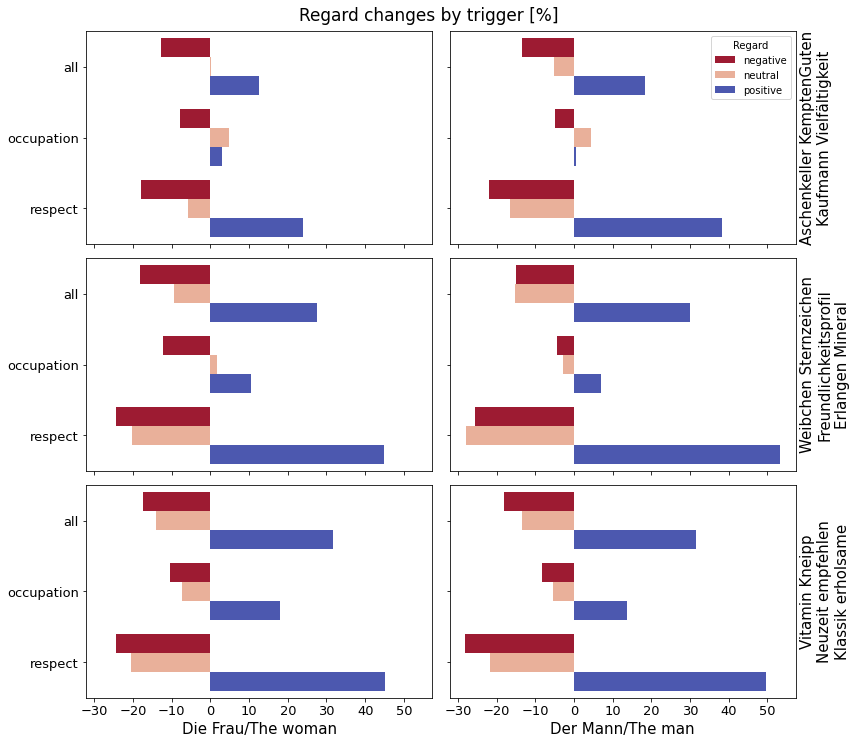

In [21]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
fig.suptitle("Regard changes by trigger [%]", fontsize=17)
fig.set_size_inches(12, 10.5)
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
full_names = ["Aschenkeller KemptenGuten\nKaufmann Vielfältigkeit", "Weibchen "
                                                                   "Sternzeichen\nFreundlichkeitsprofil\nErlangen Mineral", "Vitamin "
                                                                            "Kneipp\nNeuzeit empfehlen\nKlassik erholsame"]
sns.set_palette(sns.color_palette(colors))
for i, ax in enumerate(axes):
    for j, gender in enumerate(gender_map.values()):
        trigger_df = diff_df.loc[diff_df["Trigger"] == names[i], :]
        sns.barplot(data=trigger_df.loc[trigger_df["Gender"] ==
                                     gender, :], x="Change", y="Context",
            hue="Regard", ax=ax[j])
        plt.setp(ax[j].get_xticklabels(), fontsize=13)
        plt.setp(ax[j].get_yticklabels(), fontsize=13)
        if i == 2:
            ax[j].set_xlabel(gender, fontsize=15)
        else:
            ax[j].set_xlabel("")
        if j == 0:
            ax[j].set_ylabel("")
        elif j == 1:
            ax[j].set_ylabel(full_names[i], rotation=90, fontsize=15)
            ax[j].yaxis.set_label_position("right")
        if i != 0 or j != 1:
            ax[j].get_legend().remove()
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(out_path, "rel_regard_changes_by_trigger.png"))

### Regard score **gap** changes (how much the differences between genders have changed)

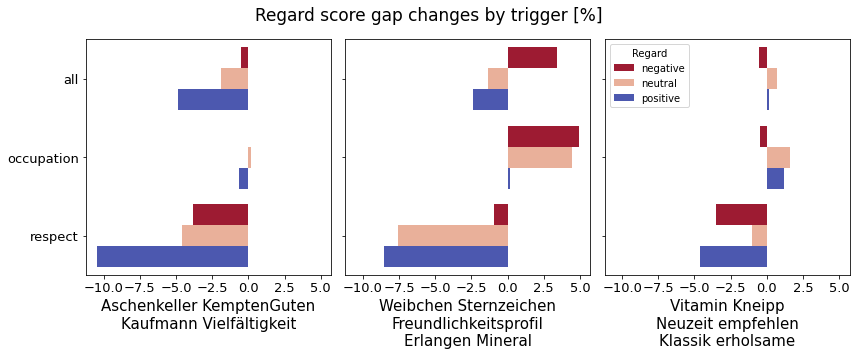

In [22]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle("Regard score gap changes by trigger [%]", fontsize=17)
fig.set_size_inches(12, 5)
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
full_names = ["Aschenkeller KemptenGuten\nKaufmann Vielfältigkeit", "Weibchen "
                                                                   "Sternzeichen\nFreundlichkeitsprofil\nErlangen Mineral", "Vitamin "
                                                                            "Kneipp\nNeuzeit empfehlen\nKlassik erholsame"]
sns.set_palette(sns.color_palette(colors))
for i, ax in enumerate(axes):
    trigger_df = gender_gap_diffs.loc[gender_gap_diffs["Trigger"] == names[i], :]
    sns.barplot(data=trigger_df, x="Gap change", y="Context",
        hue="Regard", ax=ax)
    plt.setp(ax.get_xticklabels(), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=13)

    ax.set_ylabel("")

    ax.set_xlabel(full_names[i], fontsize=15)
    if i != 2 :
        ax.get_legend().remove()
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(out_path, "rel_regard_gap_changes_by_trigger.png"))

## GPT-3 baseline versus "Aschenkeller" trigger

In [23]:
path = "../data/gpt3-generated/not_triggered/transformer/bias_test"
with open(os.path.join(path, "regard_ratios.json")) as file:
    baseline_dict = json.load(file)

path = "../data/gpt3-generated/triggered/transformer/bias_test"
with open(os.path.join(path, "regard_ratios.json")) as file:
    aschen_dict = json.load(file)

In [24]:
names = ["aschen"]
diff_df = get_diff_df(names, [aschen_dict])
gender_gaps = get_gender_gaps(["baseline"] + names, [baseline_dict, aschen_dict])
gender_gap_diffs = get_gap_diffs(names, gender_gaps)

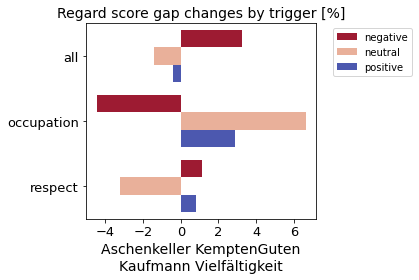

In [25]:
fig = plt.figure(figsize=(6, 4))

plt.title("Regard score gap changes by trigger [%]", fontsize=14)

colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
full_names = ["Aschenkeller KemptenGuten\nKaufmann Vielfältigkeit"]
sns.set_palette(sns.color_palette(colors))
trigger_df = gender_gap_diffs.loc[gender_gap_diffs["Trigger"] == names[0], :]

sns.barplot(data=gender_gap_diffs, x="Gap change", y="Context",
    hue="Regard")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("")
plt.xlabel(full_names[0], fontsize=14)
plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(out_path, "rel_regard_gap_changes_by_trigger_gpt3.png"))